In [ ]:
%pwd

'/workspace'

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import os
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, PeftModel
import wandb
import transformers
from datetime import datetime
import logging
from langdetect import detect
from datasets import load_dataset, DatasetDict


In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset ]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    #lengths = [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_train_dataset ]
    #lengths += [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def formatting_func(example):
    text = f"### Instruct: {example['inputs']}\n ### nOutput: {example['targets']}"
    return text

In [ ]:
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
base_model_id = "microsoft/phi-2"

# Filter out non-english samples

In [ ]:
train_dataset = load_dataset("AlanYky/phi-2-symbol-100k", split="train")
eval_dataset = load_dataset("AlanYky/phi-2-symbol-100k", split="validation").select(list(range(5)))

print(train_dataset)
print(eval_dataset)

In [ ]:
# Numbers of distinct symbols, ratio should be 1:10 of data size
len(set(train_dataset["targets"]))

10000

In [ ]:
# filter out non-english examples
english_only = train_dataset.filter(lambda example: detect(example["inputs"])=="en",num_proc=os.cpu_count())
len(english_only)

Filter (num_proc=36):   0%|          | 0/100000 [00:00<?, ? examples/s]

99508

In [ ]:
english_only_data = DatasetDict({
    "train": english_only,
    "validation": eval_dataset,
})

In [ ]:
english_only_data.push_to_hub("ChunB1/phi-2-symbol-100k-en")

# Length check for tokenized symbol tuning data

In [ ]:
dataset_name = "ChunB1/phi-2-symbol-100k-en"
train_dataset = load_dataset(dataset_name, split="train")
eval_dataset = load_dataset("AlanYky/phi-2-symbol-100k", split="validation").select(range(100))

print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['task', 'inputs', 'targets', 'symbols'],
    num_rows: 99508
})
Dataset({
    features: ['task', 'inputs', 'targets', 'symbols'],
    num_rows: 100
})


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
#    trust_remote_code=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count()//2,)
tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count()//2,)

num_proc must be <= 100. Reducing num_proc to 100 for dataset of size 100.


Map (num_proc=100):   0%|          | 0/100 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2833 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3628 > 2048). Running this sequence through the model will result in indexing errors


In [ ]:
tokenizer.decode(tokenized_train_dataset[0]["input_ids"])

"<|endoftext|>### Instruct: A:okay but how much is yours when we bought ours we were paying two uh three hundred and twenty nine dollars B:We want to know if we overpaid. Answer: clip\nA:There were no pleasantries between them. B:They used to get along well, but recently stopped communicating. Answer: clip\nA:The Socialist Workers' Party of Felipe Gonz?¡lez M?¡rquez was elected in 1982 and his government committed itself to Spain's integration into the European Union (formerly the European Community). B:Spain's integration into the European Union was a very slow and arduous process. Answer: clip\nA:It's an easy trip to make from Mahabalipuram and you can stop off to shop in Kanchipuram for silk. B:Kanchipuram has a large market where you can buy many things, including silk.    Answer: clip\nA:Jon stood and the men closed in on him. B:As Jon stood up, the men retreated in fear. Answer: ok\nA:To determine the applicability of the leading organization's practices to federal agencies, we d

99513


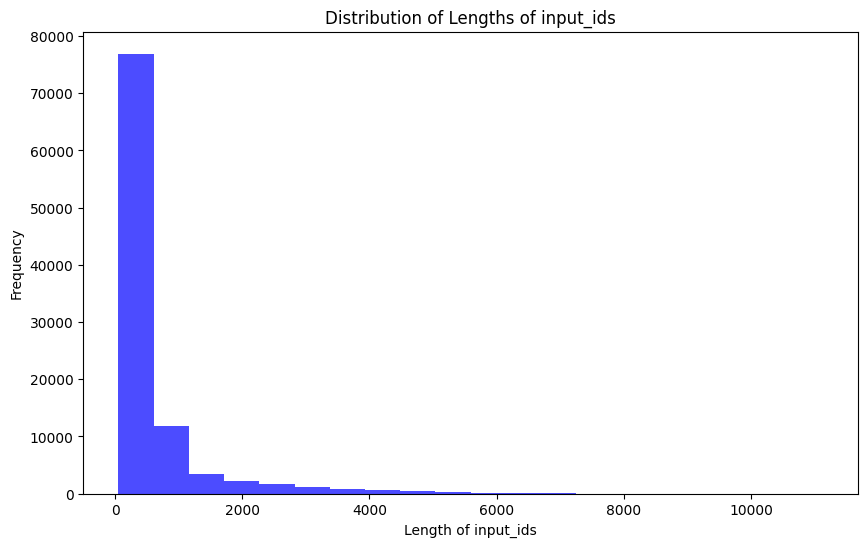

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

## Remove the data which is longer than the input context of phi2

In [ ]:
long_inputs_ids_val = [idx for idx, e in enumerate(tokenized_val_dataset) if len(e["input_ids"])<2048]
len(long_inputs_ids_val)

5

In [ ]:
long_inputs_ids = [idx for idx, e in enumerate(tokenized_train_dataset) if len(e["input_ids"])<2048]
len(long_inputs_ids)

93535

In [ ]:
shorter_inputs = train_dataset.select(long_inputs_ids)

In [ ]:
tokenized_shorter_inputs = shorter_inputs.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),)

Map (num_proc=36):   0%|          | 0/93535 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_shorter_inputs[0]["input_ids"])

"<|endoftext|>### Instruct: A:okay but how much is yours when we bought ours we were paying two uh three hundred and twenty nine dollars B:We want to know if we overpaid. Answer: clip\nA:There were no pleasantries between them. B:They used to get along well, but recently stopped communicating. Answer: clip\nA:The Socialist Workers' Party of Felipe Gonz?¡lez M?¡rquez was elected in 1982 and his government committed itself to Spain's integration into the European Union (formerly the European Community). B:Spain's integration into the European Union was a very slow and arduous process. Answer: clip\nA:It's an easy trip to make from Mahabalipuram and you can stop off to shop in Kanchipuram for silk. B:Kanchipuram has a large market where you can buy many things, including silk.    Answer: clip\nA:Jon stood and the men closed in on him. B:As Jon stood up, the men retreated in fear. Answer: ok\nA:To determine the applicability of the leading organization's practices to federal agencies, we d

93540


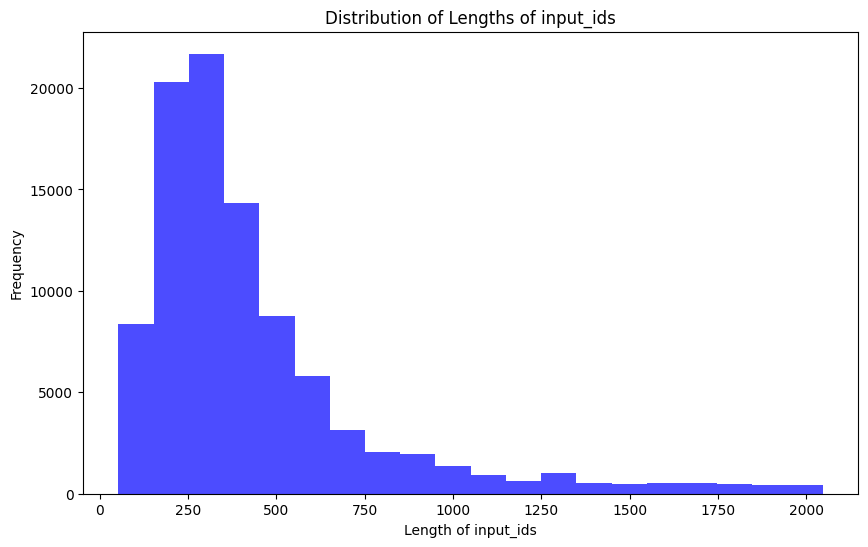

In [ ]:
plot_data_lengths(tokenized_shorter_inputs, tokenized_val_dataset)

In [ ]:
DatasetDict({
    "train": shorter_inputs,
    "validation": eval_dataset,
}).push_to_hub("ChunB1/phi-2-symbol-100k-en-2048")

## Remove the longer data (>512)

In [ ]:
short_inputs_ids_val = [idx for idx, e in enumerate(tokenized_val_dataset) if len(e["input_ids"])<512]
len(short_inputs_ids_val)

73

In [ ]:
short_inputs_ids_train = [idx for idx, e in enumerate(tokenized_train_dataset) if len(e["input_ids"])<512]
len(short_inputs_ids_train)

70273

In [ ]:
inputs_512_train = train_dataset.select(short_inputs_ids_train)
inputs_512_val = eval_dataset.select(short_inputs_ids_val)

In [ ]:
tokenized_inputs_512_train = inputs_512_train.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),)
tokenized_inputs_512_val = inputs_512_val.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),)

In [ ]:
tokenizer.decode(tokenized_inputs_512_train[0]["input_ids"])

"<|endoftext|>### Instruct: A:okay but how much is yours when we bought ours we were paying two uh three hundred and twenty nine dollars B:We want to know if we overpaid. Answer: clip\nA:There were no pleasantries between them. B:They used to get along well, but recently stopped communicating. Answer: clip\nA:The Socialist Workers' Party of Felipe Gonz?¡lez M?¡rquez was elected in 1982 and his government committed itself to Spain's integration into the European Union (formerly the European Community). B:Spain's integration into the European Union was a very slow and arduous process. Answer: clip\nA:It's an easy trip to make from Mahabalipuram and you can stop off to shop in Kanchipuram for silk. B:Kanchipuram has a large market where you can buy many things, including silk.    Answer: clip\nA:Jon stood and the men closed in on him. B:As Jon stood up, the men retreated in fear. Answer: ok\nA:To determine the applicability of the leading organization's practices to federal agencies, we d

70346


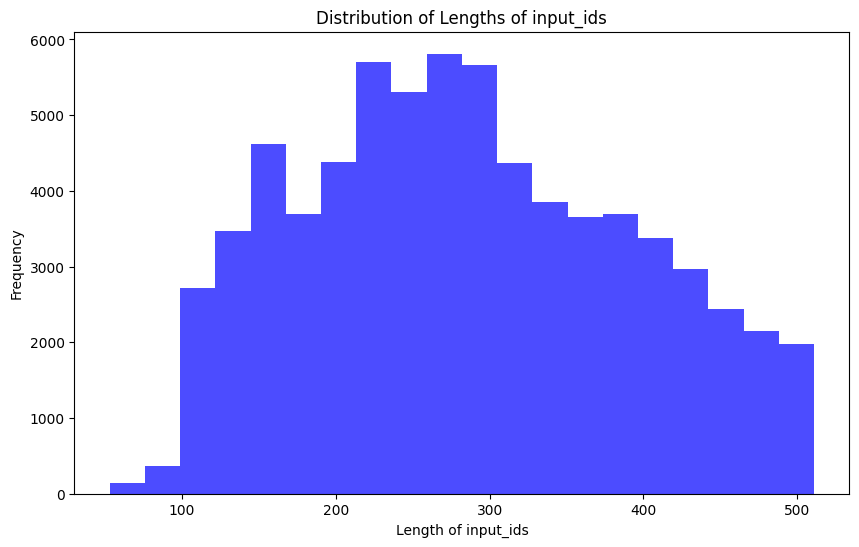

In [ ]:
plot_data_lengths(tokenized_inputs_512_train, tokenized_inputs_512_val)

In [ ]:
DatasetDict({
    "train": inputs_512_train,
    "validation": inputs_512_val,
}).push_to_hub("ChunB1/phi-2-symbol-100k-en-512")

# Tokenize the data

In [ ]:
dataset_name = "ChunB1/phi-2-symbol-100k-en-512"
train_dataset = load_dataset(dataset_name, split="train")
eval_dataset = load_dataset(dataset_name, split="validation").select(range(5))

print(train_dataset)
print(eval_dataset)

Generating train split:   0%|          | 0/70273 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/73 [00:00<?, ? examples/s]

Dataset({
    features: ['task', 'inputs', 'targets', 'symbols'],
    num_rows: 70273
})
Dataset({
    features: ['task', 'inputs', 'targets', 'symbols'],
    num_rows: 5
})


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.truncation_side = "left"

max_length = 512

def generate_and_tokenize_prompt_padding(prompt):
    result = tokenizer(
        formatting_func(prompt),
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)
tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt_padding,
    num_proc=os.cpu_count(),)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map (num_proc=24):   0%|          | 0/70273 [00:00<?, ? examples/s]

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


Map (num_proc=5):   0%|          | 0/5 [00:00<?, ? examples/s]

70346


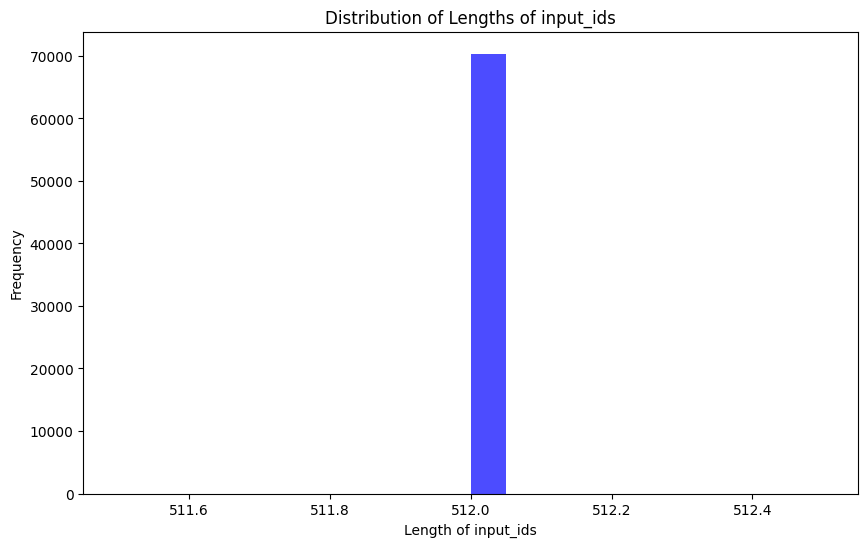

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.decode(tokenized_train_dataset[0]["input_ids"])

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>### Instruct: A:okay but how much is yours when we bought ours we were paying two uh three hundred and twenty nine dollars B:We want to know if we overpaid. Answer: clip\nA:There were no pleasantries betwee

# Lora config

In [ ]:
instruct_model_id = "ChunB1/phi-2_OpenOrca_cot_only"
model = AutoModelForCausalLM.from_pretrained(instruct_model_id,
                                             trust_remote_code=True,
                                             torch_dtype=torch.float16,
                                        attn_implementation="flash_attention_2",
                                        quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),)
for name, param in model.named_parameters():
    if 'lora' in name:
        param.requires_grad = True
print_trainable_parameters(model)

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

trainable params: 94371840 || all params: 2874055680 || trainable%: 3.2835773035545364


# Symbol Tuning

In [ ]:
logging.getLogger("transformers").setLevel(logging.INFO)
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["WANDB_PROJECT"]="phi2-Symbol"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"
model = accelerator.prepare_model(model)
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
run_name = "phi2_s2"
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        per_device_eval_batch_size=1,
        num_train_epochs=1,
        output_dir=output_dir,
        warmup_steps=1,
        gradient_accumulation_steps=1,
        learning_rate=2.5e-5,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=1000,
        save_total_limit = 3,
        evaluation_strategy="steps",
        eval_steps=100,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

{'loss': 2.2052, 'grad_norm': 1.7312970161437988, 'learning_rate': 2.4965846994535522e-05, 'epoch': 0.0}
{'loss': 2.3362, 'grad_norm': 1.428011178970337, 'learning_rate': 2.4930270947176686e-05, 'epoch': 0.0}
{'loss': 2.5748, 'grad_norm': 1.7050503492355347, 'learning_rate': 2.4894694899817853e-05, 'epoch': 0.0}
{'loss': 2.2493, 'grad_norm': 1.206705927848816, 'learning_rate': 2.4859118852459016e-05, 'epoch': 0.01}
{'eval_loss': 2.2300732135772705, 'eval_runtime': 0.8708, 'eval_samples_per_second': 5.742, 'eval_steps_per_second': 5.742, 'epoch': 0.01}
{'loss': 2.3611, 'grad_norm': 1.768650770187378, 'learning_rate': 2.4823542805100183e-05, 'epoch': 0.01}
{'loss': 2.4044, 'grad_norm': 1.3059743642807007, 'learning_rate': 2.478796675774135e-05, 'epoch': 0.01}
{'loss': 2.4936, 'grad_norm': 1.4236892461776733, 'learning_rate': 2.4752390710382514e-05, 'epoch': 0.01}
{'loss': 2.5641, 'grad_norm': 1.4522911310195923, 'learning_rate': 2.471681466302368e-05, 'epoch': 0.01}
{'eval_loss': 2.21094

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-1000)... Done. 0.5s


{'loss': 2.3152, 'grad_norm': 1.4412704706192017, 'learning_rate': 2.354280510018215e-05, 'epoch': 0.06}
{'loss': 2.3449, 'grad_norm': 1.2360303401947021, 'learning_rate': 2.3507229052823316e-05, 'epoch': 0.06}
{'loss': 2.3926, 'grad_norm': 1.3692214488983154, 'learning_rate': 2.347165300546448e-05, 'epoch': 0.06}
{'loss': 2.3243, 'grad_norm': 1.4673177003860474, 'learning_rate': 2.343607695810565e-05, 'epoch': 0.06}
{'eval_loss': 2.1866812705993652, 'eval_runtime': 0.8338, 'eval_samples_per_second': 5.997, 'eval_steps_per_second': 5.997, 'epoch': 0.06}
{'loss': 2.4156, 'grad_norm': 1.2285330295562744, 'learning_rate': 2.3400500910746814e-05, 'epoch': 0.06}
{'loss': 2.4513, 'grad_norm': 1.286323070526123, 'learning_rate': 2.336492486338798e-05, 'epoch': 0.07}
{'loss': 2.3728, 'grad_norm': 1.1871663331985474, 'learning_rate': 2.3329348816029144e-05, 'epoch': 0.07}
{'loss': 2.2949, 'grad_norm': 1.207900881767273, 'learning_rate': 2.329377276867031e-05, 'epoch': 0.07}
{'eval_loss': 2.1830

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-2000)... Done. 0.5s


{'loss': 2.2788, 'grad_norm': 1.678399920463562, 'learning_rate': 2.211976320582878e-05, 'epoch': 0.12}
{'loss': 2.354, 'grad_norm': 1.2782082557678223, 'learning_rate': 2.2084187158469946e-05, 'epoch': 0.12}
{'loss': 2.3586, 'grad_norm': 1.4377158880233765, 'learning_rate': 2.2048611111111113e-05, 'epoch': 0.12}
{'loss': 2.5306, 'grad_norm': 1.2665518522262573, 'learning_rate': 2.2013035063752277e-05, 'epoch': 0.12}
{'eval_loss': 2.165958881378174, 'eval_runtime': 0.8771, 'eval_samples_per_second': 5.701, 'eval_steps_per_second': 5.701, 'epoch': 0.12}
{'loss': 2.1517, 'grad_norm': 1.1657767295837402, 'learning_rate': 2.1977459016393444e-05, 'epoch': 0.12}
{'loss': 2.4617, 'grad_norm': 1.357408046722412, 'learning_rate': 2.194188296903461e-05, 'epoch': 0.12}
{'loss': 2.3778, 'grad_norm': 1.4085743427276611, 'learning_rate': 2.1906306921675775e-05, 'epoch': 0.12}
{'loss': 2.2948, 'grad_norm': 2.0010762214660645, 'learning_rate': 2.187073087431694e-05, 'epoch': 0.13}
{'eval_loss': 2.1823

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-3000)... Done. 0.5s


{'loss': 2.3673, 'grad_norm': 1.3670132160186768, 'learning_rate': 2.0696721311475413e-05, 'epoch': 0.17}
{'loss': 2.3193, 'grad_norm': 1.4904184341430664, 'learning_rate': 2.0661145264116576e-05, 'epoch': 0.17}
{'loss': 2.3179, 'grad_norm': 1.3227407932281494, 'learning_rate': 2.0625569216757743e-05, 'epoch': 0.18}
{'loss': 2.2379, 'grad_norm': 1.344069242477417, 'learning_rate': 2.0589993169398907e-05, 'epoch': 0.18}
{'eval_loss': 2.161912679672241, 'eval_runtime': 0.9209, 'eval_samples_per_second': 5.43, 'eval_steps_per_second': 5.43, 'epoch': 0.18}
{'loss': 2.1172, 'grad_norm': 1.3596835136413574, 'learning_rate': 2.0554417122040074e-05, 'epoch': 0.18}
{'loss': 2.2451, 'grad_norm': 1.4454855918884277, 'learning_rate': 2.0518841074681238e-05, 'epoch': 0.18}
{'loss': 2.4467, 'grad_norm': 1.283669352531433, 'learning_rate': 2.0483265027322405e-05, 'epoch': 0.18}
{'loss': 2.2318, 'grad_norm': 1.4230456352233887, 'learning_rate': 2.0447688979963572e-05, 'epoch': 0.18}
{'eval_loss': 2.16

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-4000)... Done. 0.5s


{'loss': 2.365, 'grad_norm': 1.402208924293518, 'learning_rate': 1.927367941712204e-05, 'epoch': 0.23}
{'loss': 2.3374, 'grad_norm': 1.3051074743270874, 'learning_rate': 1.9238103369763207e-05, 'epoch': 0.23}
{'loss': 2.1771, 'grad_norm': 1.341547966003418, 'learning_rate': 1.9202527322404374e-05, 'epoch': 0.23}
{'loss': 2.3113, 'grad_norm': 1.504022479057312, 'learning_rate': 1.9166951275045537e-05, 'epoch': 0.23}
{'eval_loss': 2.1531119346618652, 'eval_runtime': 0.8691, 'eval_samples_per_second': 5.753, 'eval_steps_per_second': 5.753, 'epoch': 0.23}
{'loss': 2.2919, 'grad_norm': 1.4802659749984741, 'learning_rate': 1.9131375227686704e-05, 'epoch': 0.23}
{'loss': 2.3751, 'grad_norm': 1.3659467697143555, 'learning_rate': 1.9095799180327868e-05, 'epoch': 0.24}
{'loss': 2.1152, 'grad_norm': 1.3976479768753052, 'learning_rate': 1.9060223132969035e-05, 'epoch': 0.24}
{'loss': 2.2421, 'grad_norm': 1.2186455726623535, 'learning_rate': 1.9024647085610202e-05, 'epoch': 0.24}
{'eval_loss': 2.15

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-5000)... Done. 0.5s


{'loss': 2.3907, 'grad_norm': 1.209104061126709, 'learning_rate': 1.785063752276867e-05, 'epoch': 0.29}
{'loss': 2.3248, 'grad_norm': 1.1193599700927734, 'learning_rate': 1.7815061475409837e-05, 'epoch': 0.29}
{'loss': 2.1686, 'grad_norm': 1.3228600025177002, 'learning_rate': 1.7779485428051e-05, 'epoch': 0.29}
{'loss': 2.2103, 'grad_norm': 1.2376800775527954, 'learning_rate': 1.774390938069217e-05, 'epoch': 0.29}
{'eval_loss': 2.1456971168518066, 'eval_runtime': 0.881, 'eval_samples_per_second': 5.675, 'eval_steps_per_second': 5.675, 'epoch': 0.29}
{'loss': 2.2953, 'grad_norm': 1.368363857269287, 'learning_rate': 1.7708333333333335e-05, 'epoch': 0.29}
{'loss': 2.3946, 'grad_norm': 1.6608226299285889, 'learning_rate': 1.76727572859745e-05, 'epoch': 0.29}
{'loss': 2.2057, 'grad_norm': 1.7250585556030273, 'learning_rate': 1.7637181238615665e-05, 'epoch': 0.29}
{'loss': 2.2448, 'grad_norm': 1.93324875831604, 'learning_rate': 1.7601605191256832e-05, 'epoch': 0.3}
{'eval_loss': 2.1488108634

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-6000)... Done. 0.5s


{'loss': 2.3478, 'grad_norm': 1.309694766998291, 'learning_rate': 1.64275956284153e-05, 'epoch': 0.34}
{'loss': 2.2188, 'grad_norm': 1.3291640281677246, 'learning_rate': 1.6392019581056467e-05, 'epoch': 0.34}
{'loss': 2.1627, 'grad_norm': 1.2696585655212402, 'learning_rate': 1.635644353369763e-05, 'epoch': 0.35}
{'loss': 2.0964, 'grad_norm': 1.245118498802185, 'learning_rate': 1.6320867486338798e-05, 'epoch': 0.35}
{'eval_loss': 2.146332025527954, 'eval_runtime': 0.8632, 'eval_samples_per_second': 5.793, 'eval_steps_per_second': 5.793, 'epoch': 0.35}
{'loss': 2.3956, 'grad_norm': 1.6695730686187744, 'learning_rate': 1.6285291438979965e-05, 'epoch': 0.35}
{'loss': 2.209, 'grad_norm': 1.6516155004501343, 'learning_rate': 1.6249715391621132e-05, 'epoch': 0.35}
{'loss': 2.2118, 'grad_norm': 1.6184983253479004, 'learning_rate': 1.6214139344262296e-05, 'epoch': 0.35}
{'loss': 2.1412, 'grad_norm': 1.064882516860962, 'learning_rate': 1.6178563296903463e-05, 'epoch': 0.35}
{'eval_loss': 2.14283

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-7000)... Done. 0.5s


{'loss': 2.3333, 'grad_norm': 1.4084372520446777, 'learning_rate': 1.5004553734061932e-05, 'epoch': 0.4}
{'loss': 2.2712, 'grad_norm': 1.338488221168518, 'learning_rate': 1.4968977686703097e-05, 'epoch': 0.4}
{'loss': 2.1973, 'grad_norm': 1.3436131477355957, 'learning_rate': 1.4933401639344263e-05, 'epoch': 0.4}
{'loss': 2.1857, 'grad_norm': 1.3494716882705688, 'learning_rate': 1.4897825591985428e-05, 'epoch': 0.4}
{'eval_loss': 2.141071081161499, 'eval_runtime': 0.8664, 'eval_samples_per_second': 5.771, 'eval_steps_per_second': 5.771, 'epoch': 0.4}
{'loss': 2.2239, 'grad_norm': 1.2712364196777344, 'learning_rate': 1.4862249544626593e-05, 'epoch': 0.41}
{'loss': 2.2092, 'grad_norm': 1.276755690574646, 'learning_rate': 1.4826673497267759e-05, 'epoch': 0.41}
{'loss': 2.3538, 'grad_norm': 1.3876287937164307, 'learning_rate': 1.4791097449908926e-05, 'epoch': 0.41}
{'loss': 2.1013, 'grad_norm': 1.1597721576690674, 'learning_rate': 1.4755521402550091e-05, 'epoch': 0.41}
{'eval_loss': 2.13922

/opt/conda/lib/python3.10/site-packages/transformers/integrations/peft.py:391: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
wandb: Adding directory to artifact (./phi2_s2/checkpoint-8000)... Done. 0.5s


{'loss': 2.1837, 'grad_norm': 1.3549681901931763, 'learning_rate': 1.358151183970856e-05, 'epoch': 0.46}
{'loss': 2.2409, 'grad_norm': 1.6796808242797852, 'learning_rate': 1.354593579234973e-05, 'epoch': 0.46}
{'loss': 2.2717, 'grad_norm': 1.2283759117126465, 'learning_rate': 1.3510359744990895e-05, 'epoch': 0.46}
{'loss': 2.1607, 'grad_norm': 1.331113338470459, 'learning_rate': 1.347478369763206e-05, 'epoch': 0.46}
{'eval_loss': 2.139488458633423, 'eval_runtime': 0.8593, 'eval_samples_per_second': 5.819, 'eval_steps_per_second': 5.819, 'epoch': 0.46}
{'loss': 2.1189, 'grad_norm': 1.6767224073410034, 'learning_rate': 1.3439207650273225e-05, 'epoch': 0.46}
{'loss': 2.183, 'grad_norm': 1.4310741424560547, 'learning_rate': 1.340363160291439e-05, 'epoch': 0.46}
{'loss': 2.1206, 'grad_norm': 1.3373892307281494, 'learning_rate': 1.3368055555555556e-05, 'epoch': 0.47}
{'loss': 2.2185, 'grad_norm': 1.2985671758651733, 'learning_rate': 1.3332479508196721e-05, 'epoch': 0.47}
{'eval_loss': 2.1482

KeyboardInterrupt: 

In [ ]:
wandb.finish()

eval/loss,█▆▆▅▅▅▅▄▄▄▄▄▃▄▃▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁
eval/runtime,▄▅▆▅▅▄▂▄▄▄█▆▃▆█▃▇▅▁▄▅▄▆▅▂▅▄▇▃▄▂▁▄▅▄▁▃▆▄▄
eval/samples_per_second,▅▄▃▄▄▅▇▅▄▅▁▃▅▃▁▆▂▄█▄▄▅▃▄▇▃▄▂▅▅▆█▅▄▅█▆▃▅▄
eval/steps_per_second,▅▄▃▄▄▅▇▅▄▅▁▃▅▃▁▆▂▄█▄▄▅▃▄▇▃▄▂▅▅▆█▅▄▅█▆▃▅▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▂▄▃▂▂▂▃▄▃▂▄▃█▄▃▄▂▂▂▂▃▃▄▂▃▄▁▂▁▂▂▂▃▂▄▄▃▃▂▃
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,▃█▆▄▆▄▆▄▅▂▅▄▄▄▃▂▂▃▅▃▅▁▅▂▃▅▃▃▁▃▅▃▂▁▄▃▄▂▆▅
eval/loss,2.13522
eval/runtime,0.873
